# Evaluer la qualité d’un modèle

<a href="https://github.com/linogaliana/python-datascientist/blob/master/course/modelisation/1_modelevaluation.ipynb" class="github"><i class="fab fa-github"></i></a>
[![Download](https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter.png)](https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master/course/modelisation/1_modelevaluation.ipynb)
[![nbviewer](https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter.png)](%22https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master/course/modelisation/1_modelevaluation.ipynb%22)
[![Onyxia](https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&color=yellow?logo=Python.png)](%22https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?autoLaunch=true&onyxia.friendlyName=%C2%ABpython-datascience%C2%BB&init.personalInit=%C2%ABhttps%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmaster%2Fsspcloud%2Finit-jupyter.sh%C2%BB&init.personalInitArgs=%C2%ABcourse/modelisation%201_modelevaluation.ipynb%C2%BB&security.allowlist.enabled=false%22)<br>
[![Binder](https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=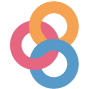.png)](https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath=course/modelisation/1_modelevaluation.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master/course/modelisation/1_modelevaluation.ipynb)
[![githubdev](https://img.shields.io/static/v1?logo=visualstudiocode&label=&message=Open%20in%20Visual%20Studio%20Code&labelColor=2c2c32&color=007acc&logoColor=007acc.png)](https://github.dev/linogaliana/python-datascientist/course/modelisation/1_modelevaluation.ipynb)

Pour illustrer le travail de données nécessaire pour construire un modèle de
Machine Learning, mais aussi nécessaire pour l’exploration de données avant de
faire une régression linéaire, nous allons partir du même jeu de données que précédemment,
c’est-à-dire les résultats des élections US 2020 présentés dans l’[introduction
de cette partie](https://linogaliana-teaching.netlify.app/modelisation/): les données de vote aux élections présidentielles US
croisées à des variables socio-démographiques.
Le code
est disponible [sur Github](https://github.com/linogaliana/python-datascientist/blob/master/content/course/modelisation/get_data.py)

## Découper l’échantillon

Le chapitre précédent présentait le pipeline simple ci-dessous
pour introduire à la notion d’entraînement d’un modèle:

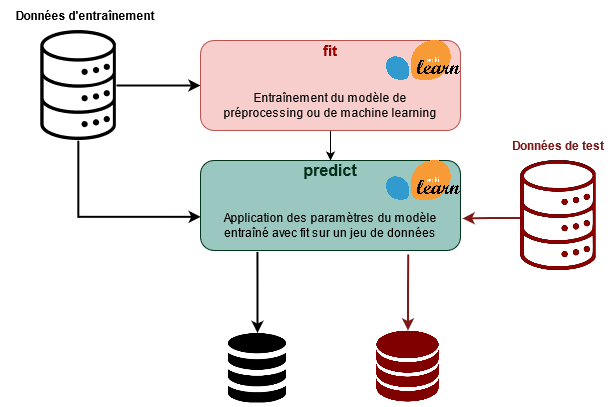

Ce *pipeline* fait abstraction d’hypothèses à faire sur des paramètres
exogènes à l’estimation mais qui affectent la performance de la prédiction.
Par exemple, de nombreux modèles proposent une pénalisation des modèles
non parcimonieux pour éviter le sur-apprentissage. Le choix de la pénalisation
idéale dépend de la structure des données et n’est jamais connue, *ex-ante*
par le modélisateur. Faut-il pénaliser fortement ou non le modèle ? En l’absence
d’argument théorique, on aura tendance à tester plusieurs paramètres de
pénalisation et choisir celui qui permet la meilleure prédiction.

La notion de validation croisée permettra de généraliser cette approche. Ces paramètres
qui affectent la prédiction seront pas la suite appelés des
**hyperparamètres**. Comme nous allons le voir, nous allons aboutir à un
raffinement de l’approche pour obtenir un *pipeline* ayant plutôt cet aspect:

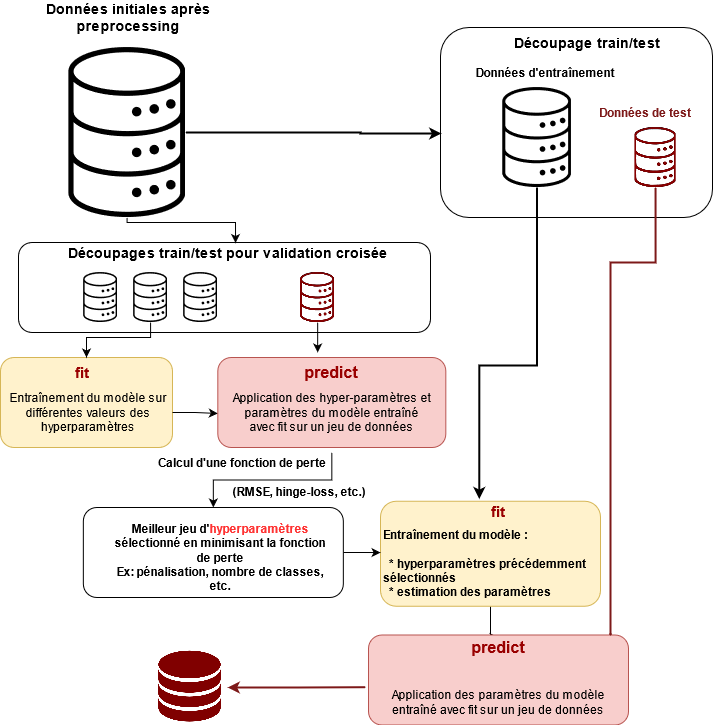

### Le problème du sur-apprentissage

Le but du *Machine Learning* est de calibrer l’algorithme sur des exemples
connus (données labellisées) afin de généraliser à des
exemples nouveaux (éventuellement non labellisés). On vise donc de bonnes qualités
prédictives et non un ajustement parfait
aux données historiques.

Il existe un arbitrage biais-variance dans la qualité d’estimation\[^1\]. Soit $h(X,\theta)$ un modèle statistique. On
peut décomposer l’erreur d’estimation en deux parties :

$$
\mathbb{E}\bigg[(y - h(\theta,X))^2 \bigg] = \underbrace{ \bigg( y - \mathbb{E}(h_\theta(X)) \bigg)^2}_{\text{biais}^2} + \underbrace{\mathbb{V}\big(h(\theta,X)\big)}_{\text{variance}}
$$

Il y a ainsi un compromis à faire entre biais et variance. Un modèle peu parcimonieux, c’est-à-dire proposant un grand nombre de paramètres, va, en général, avoir un faible biais mais une grande variance. En effet, le modèle va tendre à se souvenir d’une combinaison de paramètres à partir d’un grand nombre d’exemples sans être capable d’apprendre la règle qui permette de structurer les données.

\[^1\] Cette formule permet de bien comprendre la théorie statistique asymptotique, notamment le théorème de Cramer-Rao. Dans la classe des estimateurs sans biais, c’est-à-dire dont le premier terme est nul, trouver l’estimateur à variance minimale revient à trouver l’estimateur qui minimise $\mathbb{E}\bigg[(y - h_\theta(X))^2 \bigg]$. C’est la définition même de la régression, ce qui, quand on fait des hypothèses supplémentaires sur le modèle statistique, explique le théorème de Cramer-Rao.

Par exemple, la ligne verte ci-dessous est trop dépendante des données et risque de produire une erreur plus importante que la ligne noire (qui moyennise plus) sur de nouvelles données.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/1/19/Overfitting.svg/300px-Overfitting.svg.png)

Pour renforcer la validité externe d’un modèle, il est ainsi commun, en *Machine Learning*:

1.  d’estimer un modèle sur un jeu de données (jeu d’apprentissage ou *training set*) mais d’évaluer la performance, et donc la pertinence, du modèle sur d’autres données (jeu de validation, de test ou *testing set*) ;
2.  avoir des mesures de performances qui pénalisent fortement les modèles peu parcimonieux (BIC) ou conduire une première phase de sélection de variable (par des méthodes de LASSO…)

Pour décomposer un modèle en jeu d’estimation et de test, la meilleure méthode est d’utiliser les fonctionnalités de `scikit` de la manière suivante :

In [3]:
from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(x, y,
test_size = 0.2, random_state = 0)

La proportion d’observations dans le jeu de test est contrôlée par l’argument `test_size`. La proportion optimale n’existe pas ; la règle du pouce habituelle est d’assigner aléatoirement 20 % des observations dans l’échantillon de test pour garder suffisamment d’observations dans l’échantillon d’estimation.

{{% box status=“warning” title=“Warning” icon=“fa fa-exclamation-triangle” %}}
Lorsqu’on travaille avec des séries temporelles, l’échantillonnage aléatoire des observations n’a pas vraiment de sens. Il vaut mieux tester la qualité de l’observation sur des périodes distinguées.
{{% /box %}}

{{% box status=“note” title=“Note” icon=“fa fa-comment” %}}
Avec des données multi-niveaux, comme c’est le cas de données géographiques ou de données individuelles avec des variables de classe, il peut être intéressant d’utiliser un échantillonnage stratifié. Cela permet de garder une proportion équivalente de chaque groupe dans les deux jeux de données de test ou d’apprentissage. Ce type d’échantillonnage stratifié est également possible avec `scikit`.
{{% /box %}}

L’[exercice sur les SVM](https://linogaliana-teaching.netlify.app/svm/) illustre cette construction et la manière
dont elle facilite l’évaluation de la qualité d’un modèle.

### Validation croisée

Certains algorithmes font intervenir des hyperparamètres, c’est-à-dire des paramètres exogènes qui déterminent la prédiction mais ne sont pas estimés. La validation croisée est une méthode permettant de choisir la valeur du paramètre qui optimise la qualité de la prédiction en agrégeant des scores de performance sur des découpages différents de l’échantillon d’apprentissage.
La validation croisée permet d’évaluer les performances de modèles différents (SVM, random forest, etc.) ou, couplé à une stratégie de *grid search* de trouver les valeurs des hyperparamètres qui aboutissent à la meilleure prédiction.

{{% box status=“warning” title=“Warning” icon=“fa fa-exclamation-triangle” %}}
L’étape de découpage de l’échantillon de validation croisée est à distinguer de l’étape `split_sample_test`. A ce stade, on a déjà partitionné les données en échantillon d’apprentissage et test. C’est l’échantillon d’apprentissage qu’on découpe en sous-morceaux.
{{% /box %}}

La méthode la plus commune est la validation croisée k-fold. On partitionne les données en *K* morceaux et on considère chaque pli, tour à tour, comme un échantillon
de test en apprenant sur les *K-1* échantillons restants. Les *K* indicateurs ainsi calculés sur les *K* échantillons de test peuvent être moyennés et
comparés pour plusieurs valeurs des hyperparamètres.

![](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

Il existe d’autres types de validation croisée, notamment la *leave one out* qui consiste à considérer une fois
exactement chaque observation comme l’échantillon de test (une *n-fold cross validation*).

## Mesurer la performance

Jusqu’à présent, nous avons passé sous silence la question du support de $y$. En pratique, celui-ci va néanmoins déterminer deux questions cruciales : la méthode et l’indicateur de performance.

En apprentissage supervisé, on distingue en général les problèmes de:

-   Classification : la variable $y$ est discrète
-   Régression : la variable $y$ est continue

Les deux approches ne sont pas sans lien. On peut par exemple voir le modèle économétrique de choix d’offre de travail comme un problème de classification (participation ou non au marché du travail) ou de régression (régression sur un modèle à variable latente)

### Classification

La plupart des critères de performance sont construits à partir de la **matrice de confusion**:

![Image empruntée à https://www.lebigdata.fr/confusion-matrix-definition](https://www.lebigdata.fr/wp-content/uploads/2018/12/confusion-matrix-exemple-768x432.jpg?ezimgfmt=ng:webp/ngcb1.png)

A partir des 4 coins de cette matrice, il existe plusieurs mesure de performance

| Critère           | Mesure                                                               | Calcul                                                 |
|---------------------|-----------------------|-----------------------------|
| *Accuracy*        | Taux de classification correcte                                      | Diagonale du tableau: $\frac{TP+TN}{TP+FP+FN+FP}$      |
| *Precision*       | Taux de vrais positifs                                               | Ligne des prédictions positives: $\frac{TP}{TP+FP}$    |
| *Recall* (rappel) | Capacité à identifier les labels positifs                            | Colonne des prédictions positives: $\frac{TP}{TP+FN}$  |
| *F1 Score*        | Mesure synthétique (moyenne harmonique) de la précision et du rappel | $2 \frac{precision \times recall}{precision + recall}$ |

En présence de classes désequilibrées, la
F-mesure est plus pertinente pour évaluer les
performances mais l’apprentissage restera
mauvais si l’algorithme est sensible à ce
problème. Notamment, si on désire avoir une performance équivalente sur les classes minoritaires, il faut généralement les sur-pondérer (ou faire un échantillonnage stratifié) lors de la constitution de l’échantillon d’observation.

Il est possible de construire des modèles à partir des probabilités prédites d’appartenir à la classe d’intérêt. Pour cela, on fixe un seuil $c$ tel que

$$
\mathbb{P}(y_i=1|X_i) > c \Rightarrow \widehat{y}_i = 1 
$$

Plus on augmente $c$, plus on est sélectif sur le critère d’appartenance à la classe. Le rappel, i.e. le taux de faux négatifs, diminue. Mais on augmente le nombre de positifs manqués. Pour chaque valeur de $c$ correspond une matrice de confusion et donc des mesures de performances. La **courbe ROC** est un outil classique pour représenter en un graphique l’ensemble de ces
informations en faisant varier $c$ de 0 à 1

![](https://glassboxmedicine.files.wordpress.com/2019/02/roc-curve-v2.png?w=576)

L’aire sous la courbe (**AUC**) permet d’évaluer quantitativement le meilleur modèle au
sens de ce critère. L’AUC représente la probabilité que le modèle soit capable de distinguer entre la classe positive et négative.

### Régression

En Machine Learning, les indicateurs de performance en régression sont les suivants:

| Nom                            | Formule                                                               |
|--------------------------|----------------------------------------------|
| Mean squared error             | $MSE = \mathbb{E}\left[(y - h_\theta(X))^2\right]$                    |
| Root Mean squared error        | $RMSE = \sqrt{\mathbb{E}\left[(y - h_\theta(X))^2\right]}$            |
| Mean Absolute Error            | $MAE = \mathbb{E}\left[ |y - h_\theta(X)| \right]$                    |
| Mean Absolute Percentage Error | $MAE = \mathbb{E}\left[\left|\frac{y - h_\theta(X)}{y}\right|\right]$ |

L’économètre se focalise moins sur la qualité de la prédiction et utilisera
d’autres critères pour évaluer la qualité d’un modèle (certains, comme le BIC, sont
à regarder aussi dans une optique *Machine Learning*): $R^2$, $BIC$,
$AIC$, *log-likelihood*, etc.